In [1]:
import rosbag
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tf
from scipy.signal import find_peaks

In [2]:

bag = rosbag.Bag('/home/hakanergin/code/rosbags/static/translation/25h9_s_z_2-4-6-8-10_1080_20.bag')

# create variables
target = 'distance - z'
true_value = 'true_distance'

# input values in meters. the order matters, it will be used for binning 
input_vals = [2,4,6,8,10]

In [3]:
topic = '/tf'

rows = []

for topic, msg, t in bag.read_messages(topics=topic):
    
    time = t
    distance = msg.transforms[0].transform.translation.z

    # print(msg.transforms[0].header.stamp.secs, msg.transforms[0].header.stamp.nsecs)
    
    # create row
    row={'time': time.to_sec(), target: distance}
    rows.append(row)

df = pd.DataFrame.from_records(rows)

In [4]:
# calculate relative time in seconds instead of absolute time
df['relative_time'] =  df.loc[0:, 'time'] - df.at[0, 'time']
df = df.drop(columns=['time'])
df = df[['relative_time', target]]
df

,relative_time,distance - z
0,0.000000,1.931783
1,0.976528,2.001271
2,1.258881,1.996881
3,1.548243,1.994261
4,1.857116,2.000899
...,...,...
412,119.841149,9.935479
413,120.118625,9.942376
414,120.726099,9.726252
415,126.503969,1.890518


<AxesSubplot:xlabel='relative_time'>

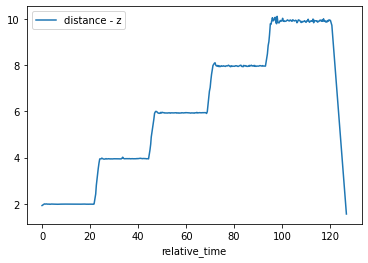

In [5]:
# initial graph
df.plot(x='relative_time', y=target)

In [6]:
# find plateaus
x = df[target]
peaks, _ = find_peaks(x, threshold=(0, 1)) # from find_peaks docs: Threshold: The first element is always interpreted as the minimal and the second, if supplied, as the maximal required threshold.

In [7]:
# the amount of data points we are left with
len(x[peaks])

124

In [8]:
# create filtered data frame
df_filtered_by_targets = df.loc[peaks]

<AxesSubplot:xlabel='relative_time', ylabel='distance - z'>

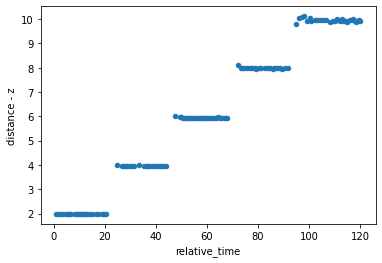

In [9]:
df_filtered_by_targets.plot.scatter(x='relative_time', y=target)

In [10]:
# segmenting/binning by real value
df_filtered_by_targets[true_value] = pd.cut(df_filtered_by_targets[target], bins=len(input_vals), labels=input_vals)
len(df_filtered_by_targets)

124

In [11]:
# calculate the error
df_filtered_by_targets['error'] =  df_filtered_by_targets.apply(lambda row: row[true_value] - row[target], axis=1)

In [12]:
grouped_df = df_filtered_by_targets.groupby(true_value)

In [13]:
# verify if the bins are in correct order, this is dictated by input_vals order
grouped_df.head(2)

,relative_time,distance - z,true_distance,error
1,0.976528,2.001271,2,-0.001271
4,1.857116,2.000899,2,-0.000899
83,24.915954,3.983166,4,0.016834
89,26.660823,3.962232,4,0.037768
162,47.416793,6.005608,6,-0.005608
169,49.373429,5.958435,6,0.041565
246,72.064209,8.107470,8,-0.107470
250,73.220358,7.990229,8,0.009771
325,95.100669,9.792057,10,0.207943
328,95.960676,10.056193,10,-0.056193


In [14]:
grouped_df.error.describe()

,count,mean,std,min,25%,50%,75%,max
true_distance,,,,,,,,
2,23.0,0.007065,0.003327,-0.001271,0.005578,0.007301,0.009167,0.012242
4,20.0,0.036259,0.015831,-0.022169,0.034574,0.040827,0.043960,0.049616
6,29.0,0.052886,0.013390,-0.005608,0.050444,0.056175,0.059276,0.064769
8,22.0,0.012147,0.029429,-0.107470,0.007480,0.016651,0.023960,0.043766
10,30.0,0.044781,0.060361,-0.114698,0.031793,0.056459,0.074693,0.207943


In [15]:
def box_plotter(column_name):
    fig, axes = plt.subplots(1,len(input_vals))

    for i, val in enumerate(input_vals):
        grouped_df.get_group(val).boxplot(column=column_name, ax=axes.flatten()[i])
        axes.flatten()[i].set_title(val)


    plt.tight_layout()
    plt.show()

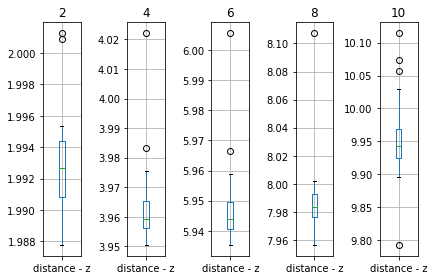

In [16]:
box_plotter(target)

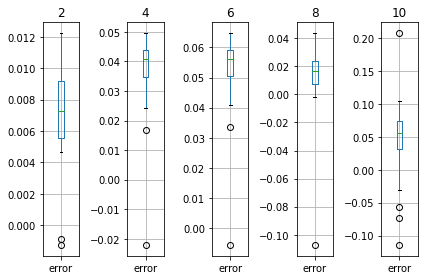

In [17]:
box_plotter('error')

In [18]:
df_filtered_by_targets.to_csv('/home/hakanergin/code/apriltag_test_bench/test_pipeline/scripts/static_tests/translations/result/csv/25h9_1080.csv')